# Project: Metadata Suggesties voor Online Lesmateriaal

##1. Inleiding
In dit ptoject dat we gaan uitvoeren voor de organisatie Wikiwijs is ons doel om metdatasuggesties voor het online lesmateriaal van Wikiwijs te gaan maken. We willen dat ons model uiteindelijk accurate metadata suggesties gaat geven voor het leerjaar, het niveau en het vak.

## 2. Gegevens Onderzoeken en Begrijpen

In deze sectie verkennen we de structuur van onze dataset. We richten ons op JSON-bestanden die lesmateriaal bevatten, specifiek op het bestand vmbo1.json in de submap 'Bio'.

In [1]:
import os
import json
import pandas as pd
# Specificeer het pad naar de submap 'Bio' waar 'vmbo1.json' zich bevindt
directory_path = '/Users/jesse/Downloads/json_mini'

# Bestandsnaam van het voorbeeld JSON-bestand
file_name = '13.json'
file_path = os.path.join(directory_path, file_name)

# Lees het JSON-bestand en print de inhoud om de structuur te begrijpen
try:
    with open(file_path, 'r', encoding='utf-8') as file:
        data = json.load(file)
        print(json.dumps(data, indent=4))  # Print de inhoud met een nette indeling
except Exception as e:
    print(f"Error bij het lezen van bestand {file_name}: {e}")


{
    "documentAuthors": [
        "Marjolein Kalter"
    ],
    "uuid": null,
    "authors": [
        {
            "fullName": "Marjolein Kalter",
            "referenceName": null,
            "reference": {
                "value": "6"
            },
            "firstName": "Marjolein",
            "infix": "",
            "lastName": "Kalter",
            "emailAddress": "marjolein@anderszins.com",
            "type": "author"
        }
    ],
    "documentDate": "2010-02-08T15:52:23Z",
    "bulkId": "bulk-17041135-refresh_all",
    "identifier": 13,
    "title": "Vormgeven van je arrangement",
    "description": "Instructie hoe de vormgeving van een arrangement aan te passen is",
    "lastModifiedDate": "2010-02-08T15:52:23+01:00",
    "dateCreated": "2009-10-27T17:09:40+01:00",
    "published": true,
    "publisher": null,
    "team": {
        "reference": {
            "value": "wikiwijs_maken_authors"
        },
        "name": "Wikiwijs Maken Auteurs",
        "members": [

**Analyse van vmbo1.json Inhoud**
De JSON-data van vmbo1.json biedt een diepgaand inzicht in het structuur en inhoud van het online lesmateriaal voor het thema "Omgeving" voor vmbo-b12. Hieronder volgt een gedetailleerde analyse van de sleutelcomponenten binnen het bestand:

**Metadata en Auteursinformatie**
Document Auteurs: Het document bevat namen van diverse auteurs, waaronder Pieter Bruring en Sophia Kambakhsh, die bijdragen hebben geleverd aan de inhoud
.

Publicatiedatum: De inhoud is laatst gewijzigd op 25 mei 2023, wat aangeeft dat het materiaal recent is bijgewerkt.


Licentie: Het materiaal valt onder de "CC Naamsvermelding-GelijkDelen 4.0 Internationale licentie", wat betekent dat gebruikers het werk mogen kopiëren, verspreiden, doorgeven, en afgeleide werken mogen maken onder bepaalde voorwaarden.


**Inhoud en Structuur**
Titel: "Thema Omgeving vmbo-b12" geeft duidelijk het onderwerp en het doelpubliek van het lesmateriaal aan.


Beschrijving: Er is een korte inleiding die het thema en de kernonderwerpen beschrijft, zoals levenskenmerken en voedselketens.


Secties: Het document is opgedeeld in verschillende secties, zoals "Intro", "Wat kan ik straks?", en "Wat ga ik doen?", die elk specifieke leerdoelen en activiteiten bevatten. Dit wijst op een gestructureerde benadering om de leerinhoud te presenteren.


**Educatieve Componenten**
Leerdoelen: Voor elke sectie worden specifieke leerdoelen vermeld, zoals het kunnen noemen van negen levenskenmerken en het beschrijven van de begrippen voedselketen en voedselweb.


Opdrachten: Er zijn diverse opdrachten opgenomen met duidelijke instructies en verwachte leeruitkomsten, wat bijdraagt aan een interactieve leerervaring.


Multimedia-inhoud: Het gebruik van afbeeldingen en ingesloten video's verrijkt de tekstuele inhoud en biedt een meer boeiende leerervaring.


**Reflectie en Evaluatie**
Diagnostische toets: Aan het eind van het thema is er een diagnostische toets om de kennis van de leerlingen te evalueren, wat essentieel is voor het beoordelen van het begrip van de leerstof.


Terugkijken: Er is een sectie gewijd aan zelfreflectie, waar leerlingen worden aangemoedigd om na te denken over wat ze hebben geleerd en hoe het proces is verlopen.


**Conclusie**
De inhoud van vmbo1.json toont een goed doordacht en uitgebreid lesmateriaal dat zorgvuldig is ontworpen om vmbo-b12 leerlingen te onderwijzen over het thema "Omgeving". De combinatie van gestructureerde informatie, duidelijke leerdoelen, interactieve opdrachten, en multimedia-inhoud maakt dit een waardevolle bron voor zowel leerlingen als docenten.

##2. Bouw een Input Datapipeline voor Tekst-Preprocessing

We gebruiken BeautifulSoup om HTML-content te verwijderen en reguliere expressies (re) om overbodige spaties te verwijderen. Vervolgens extraheren we de tekst uit elke sectie van onze JSON-bestanden.


In [2]:
from bs4 import BeautifulSoup
import re

def clean_html(raw_html):
    """Functie om HTML-content te verwerken en overbodige spaties te verwijderen."""
    soup = BeautifulSoup(raw_html, "html.parser")
    text = soup.get_text(separator=' ')
    text = re.sub('\s+', ' ', text).strip()
    return text

def extract_text_from_section(section):
    """Functie om inhoud uit secties te halen, inclusief subsecties."""
    text = section.get('heading', {}).get('content', '') + " "
    for item in section.get('items', []):
        text += item.get('content', '') + " "
    for subsection in section.get('sections', []):
        text += extract_text_from_section(subsection)
    return text


Nu we onze functies voor het schoonmaken en extraheren van tekst hebben, kunnen we deze toepassen op onze dataset. We lezen elk JSON-bestand uit onze dataset, extraheren de tekst met behulp van onze functies, en slaan de schone teksten op voor verdere verwerking.




In [3]:
import os
import json

# Map waarin alle vakmappen zijn opgeslagen
directory_path = '/Users/jesse/Downloads/json_mini'

# Lijst om alle geëxtraheerde teksten op te slaan
all_texts = []

# Itereren over alle submappen (vakmappen)
for subdir in os.listdir(directory_path):
    subdirectory_path = os.path.join(directory_path, subdir)
    if os.path.isdir(subdirectory_path):
        for filename in os.listdir(subdirectory_path):
            if filename.endswith('.json'):
                file_path = os.path.join(subdirectory_path, filename)
                try:
                    with open(file_path, 'r', encoding='utf-8') as file:
                        data = json.load(file)
                    processed_text = clean_html(extract_text_from_section(data))
                    all_texts.append(processed_text)
                except Exception as e:
                    print(f"Fout bij het verwerken van bestand {filename}: {e}")

# Weergeven van de geëxtraheerde teksten
print(all_texts)


[]


Met deze pipeline voor tekst-preprocessing hebben we nu een schone, gestructureerde tekstinput die kan worden gebruikt voor verdere verwerking, zoals feature extractie of direct in een machine learning model. doordat deze functie iterateert over alle submappen zullen de lessen voor elk vak worden meegenomen.

In [4]:
def compare_texts(raw_html):
    """Functie om de originele en opgeschoonde tekst naast elkaar te tonen."""
    print("Originele Tekst:")
    print(raw_html)
    print("\nOpgeschoonde Tekst:")
    cleaned_text = clean_html(raw_html)
    print(cleaned_text)

# Voorbeeld HTML-tekst
raw_html_example = "<div>Dit is een <b>voorbeeld</b> tekst met <a href='https://example.com'>een link</a> en wat andere <i>HTML</i> elementen.<br />En een nieuwe regel.</div>"

# Vergelijk de originele met de opgeschoonde tekst
compare_texts(raw_html_example)


Originele Tekst:
<div>Dit is een <b>voorbeeld</b> tekst met <a href='https://example.com'>een link</a> en wat andere <i>HTML</i> elementen.<br />En een nieuwe regel.</div>

Opgeschoonde Tekst:
Dit is een voorbeeld tekst met een link en wat andere HTML elementen. En een nieuwe regel.


In [5]:
import tensorflow as tf

# Omzetten van de lijst met opgeschoonde teksten naar een TensorFlow Dataset
texts_dataset = tf.data.Dataset.from_tensor_slices(all_texts)

# Voorbeeld om de eerste paar elementen van de dataset te bekijken
for text in texts_dataset.take(3):
    print(text.numpy())


In [6]:
class ETLPipeline:
    VALID_SUBJECTS = {
        "Aardrijkskunde", "Algemene natuurwetenschappen", "Arabisch", 
        "Audiovisuele vormgeving", "Beeldende vormgeving", "Bewegen, sport en maatschappij", 
        "Biologie", "Chinees", "Culturele en kunstzinnige vorming", 
        "Dans", "Drama", "Duits", "Economie", "Engels", "Filosofie",
        "Frans", "Fries", "Geschiedenis", "Godsdienst", "Grieks", 
        "Handvaardigheid", "Informatica", "Italiaans", "Klassieke culturele vorming", 
        "Kunst algemeen", "Kunst en cultuur", "Latijn", "Levensbeschouwing", 
        "Lichamelijke opvoeding", "Lichamelijke opvoeding (gemeenschappelijk deel)", 
        "Literatuur", "Maatschappijleer", "Maatschappijleer (gemeenschappelijk deel)", 
        "Maatschappijwetenschappen", "Management en organisatie", "Mens en maatschappij", 
        "Mens en natuur", "Muziek", "NaSk", "NaSk1", "NaSk2", 
        "Natuur, leven en technologie", "Natuur- en milieueducatie", "Natuurkunde", 
        "Nederlands", "Nederlands als tweede taal", "Portugees", 
        "Rekenen/wiskunde", "Russisch", "Scheikunde", "Spaans", "Techniek", 
        "Tekenen", "Textiele vormgeving", "Turks", "Verzorging", "Wiskunde A", 
        "Wiskunde B", "Wiskunde C", "Wiskunde D"
    }
    
    def __init__(self, directory_path):
        self.directory_path = directory_path
        self.all_texts = []
        self.vakken = []
        self.leerjaren = []
        self.niveaus = []

    def clean_html(self, raw_html):
        soup = BeautifulSoup(raw_html, "html.parser")
        text = soup.get_text(separator=' ')
        text = re.sub('\s+', ' ', text).strip()
        return text

    def extract_text_from_section(self, section):
        text = section.get('heading', {}).get('content', '') + " "
        for item in section.get('items', []):
            text += item.get('content', '') + " "
        for subsection in section.get('sections', []):
            text += self.extract_text_from_section(subsection)
        return text

    def extract_text(self):
        for subdir, _, files in os.walk(self.directory_path):
            for filename in files:
                if filename.endswith('.json'):
                    file_path = os.path.join(subdir, filename)
                    try:
                        with open(file_path, 'r', encoding='utf-8') as file:
                            data = json.load(file)
                        processed_text = self.clean_html(self.extract_text_from_section(data))
                        self.all_texts.append(processed_text)
                        self.extract_metadata(data)  # Extract metadata
                    except Exception as e:
                        print(f"Error processing file {filename}: {e}")

    def extract_metadata(self, data):
        vakken_set = set()
        leerjaren_set = set()
        niveaus_set = set()

        for term in data.get('colophon', {}).get('metadata', []):
            if not isinstance(term, dict):
                print(f"Issue with metadata entry: {term}")
                continue

            key = term.get('key')
            terms = term.get('terms')

            if key == 'disciplines':
                if terms is not None and isinstance(terms, (dict, list)):
                    if isinstance(terms, dict):
                        elements = terms.values()
                    else:
                        elements = terms
                    for element in elements:
                        vakken_set.update(map(lambda x: x.strip(), element.split(',')))
                else:
                    print(f"Issue with 'disciplines' metadata: {terms}")
            elif key == 'educationalLevels':
                if terms is not None and isinstance(terms, dict):
                    for value in terms.values():
                        if value is not None:
                            leerjaren_set.update(re.findall(r'\b\d+\b', value))
                            levels = map(lambda x: x.strip(), value.split(','))
                            niveaus_set.update(levels)
                else:
                    print(f"Issue with 'educationalLevels' metadata: {terms}")

        vakken_set = vakken_set.intersection(self.VALID_SUBJECTS)
        
        self.vakken.append(', '.join(sorted(vakken_set)))
        self.leerjaren.append(', '.join(sorted(leerjaren_set, key=int)))
        self.niveaus.append(', '.join(sorted(niveaus_set)))
    
    def create_dataframe(self):
        df = pd.DataFrame({'text': self.all_texts, 
                           'vakken': self.vakken, 
                           'leerjaren': self.leerjaren, 
                           'niveaus': self.niveaus})
    
        df = df[df['vakken'] != '']
        return df

# Usage
directory_path = '/Users/jesse/Downloads/json_mini'
pipeline = ETLPipeline(directory_path)
pipeline.extract_text()
dataframe = pipeline.create_dataframe()

print(dataframe.head())

C:\Users\jesse\AppData\Local\Temp\ipykernel_11160\3883108082.py:29: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(raw_html, "html.parser")


                                                 text                vakken  \
12  English Tenses overview Met deze overzichten k...                Engels   
15  Introductie Deze les gaat over gezond en bewus...  Biologie, Verzorging   
28  0. Voor de docent 1. Zakelijke teksten 1.a. Ve...            Nederlands   
33  0. Voor de docent 1. Zakelijke teksten Signaal...            Nederlands   
34  Wiskunde A - Havo 4 en 5 Het complete examenpr...      Rekenen/wiskunde   

     leerjaren                                            niveaus  
12     4, 5, 6                HAVO 4, HAVO 5, VWO 4, VWO 5, VWO 6  
15  1, 2, 3, 4  1, 2, 3, 4, HAVO 1, HAVO 2, HAVO 3, MBO, Nivea...  
28           1                                      HAVO 1, VWO 1  
33           2                                      HAVO 2, VWO 2  
34        4, 5                                     HAVO 4, HAVO 5  


In [7]:
dataframe

,text,vakken,leerjaren,niveaus
12,English Tenses overview Met deze overzichten k...,Engels,"4, 5, 6","HAVO 4, HAVO 5, VWO 4, VWO 5, VWO 6"
15,Introductie Deze les gaat over gezond en bewus...,"Biologie, Verzorging","1, 2, 3, 4","1, 2, 3, 4, HAVO 1, HAVO 2, HAVO 3, MBO, Nivea..."
28,0. Voor de docent 1. Zakelijke teksten 1.a. Ve...,Nederlands,1,"HAVO 1, VWO 1"
33,0. Voor de docent 1. Zakelijke teksten Signaal...,Nederlands,2,"HAVO 2, VWO 2"
34,Wiskunde A - Havo 4 en 5 Het complete examenpr...,Rekenen/wiskunde,"4, 5","HAVO 4, HAVO 5"
38,Leerlijn Negatieve getallen Deze leerlijn best...,Rekenen/wiskunde,1,"HAVO 1, VWO 1"
42,Bodem van Nederland arrangement gemaakt door H...,"Aardrijkskunde, Algemene natuurwetenschappen, ...","1, 2, 3, 4, 5, 6","2, 4, Beroepsonderwijs en Volwasseneneducatie,..."
51,0. Voor de docent 1. Zakelijke teksten 1.06 De...,Nederlands,3,"HAVO 3, VWO 3"
135,Algemene informatie Onderwerpen De collectie b...,Rekenen/wiskunde,1,"HAVO 1, VWO 1"
159,Inleiding Inleiding (20 minuten) Welkom bij de...,Muziek,"6, 7, 8","PO groep 6, PO groep 7, PO groep 8, SO"


In [8]:
empty_vakken_rows = dataframe[dataframe['vakken'] == '']
empty_vakken_rows.head(10)



,text,vakken,leerjaren,niveaus


## Kleine EDA

In [9]:
df = dataframe
df

,text,vakken,leerjaren,niveaus
12,English Tenses overview Met deze overzichten k...,Engels,"4, 5, 6","HAVO 4, HAVO 5, VWO 4, VWO 5, VWO 6"
15,Introductie Deze les gaat over gezond en bewus...,"Biologie, Verzorging","1, 2, 3, 4","1, 2, 3, 4, HAVO 1, HAVO 2, HAVO 3, MBO, Nivea..."
28,0. Voor de docent 1. Zakelijke teksten 1.a. Ve...,Nederlands,1,"HAVO 1, VWO 1"
33,0. Voor de docent 1. Zakelijke teksten Signaal...,Nederlands,2,"HAVO 2, VWO 2"
34,Wiskunde A - Havo 4 en 5 Het complete examenpr...,Rekenen/wiskunde,"4, 5","HAVO 4, HAVO 5"
38,Leerlijn Negatieve getallen Deze leerlijn best...,Rekenen/wiskunde,1,"HAVO 1, VWO 1"
42,Bodem van Nederland arrangement gemaakt door H...,"Aardrijkskunde, Algemene natuurwetenschappen, ...","1, 2, 3, 4, 5, 6","2, 4, Beroepsonderwijs en Volwasseneneducatie,..."
51,0. Voor de docent 1. Zakelijke teksten 1.06 De...,Nederlands,3,"HAVO 3, VWO 3"
135,Algemene informatie Onderwerpen De collectie b...,Rekenen/wiskunde,1,"HAVO 1, VWO 1"
159,Inleiding Inleiding (20 minuten) Welkom bij de...,Muziek,"6, 7, 8","PO groep 6, PO groep 7, PO groep 8, SO"


Wij zien in deze dataframe dat er lessen zijn voor PO, met leerjaar 1-8. Wij willen alleen lessen uit het voortgezet onderwijs.

In [10]:
# Assuming df is your DataFrame
df.drop(df[df['niveaus'].str.contains('PO groep') | df['niveaus'].str.contains('HBO - Bachelor')].index, inplace=True)


Nu kunnen we deze PO content uit de dataset halen.

In [11]:
df



,text,vakken,leerjaren,niveaus
12,English Tenses overview Met deze overzichten k...,Engels,"4, 5, 6","HAVO 4, HAVO 5, VWO 4, VWO 5, VWO 6"
15,Introductie Deze les gaat over gezond en bewus...,"Biologie, Verzorging","1, 2, 3, 4","1, 2, 3, 4, HAVO 1, HAVO 2, HAVO 3, MBO, Nivea..."
28,0. Voor de docent 1. Zakelijke teksten 1.a. Ve...,Nederlands,1,"HAVO 1, VWO 1"
33,0. Voor de docent 1. Zakelijke teksten Signaal...,Nederlands,2,"HAVO 2, VWO 2"
34,Wiskunde A - Havo 4 en 5 Het complete examenpr...,Rekenen/wiskunde,"4, 5","HAVO 4, HAVO 5"
38,Leerlijn Negatieve getallen Deze leerlijn best...,Rekenen/wiskunde,1,"HAVO 1, VWO 1"
42,Bodem van Nederland arrangement gemaakt door H...,"Aardrijkskunde, Algemene natuurwetenschappen, ...","1, 2, 3, 4, 5, 6","2, 4, Beroepsonderwijs en Volwasseneneducatie,..."
51,0. Voor de docent 1. Zakelijke teksten 1.06 De...,Nederlands,3,"HAVO 3, VWO 3"
135,Algemene informatie Onderwerpen De collectie b...,Rekenen/wiskunde,1,"HAVO 1, VWO 1"
207,Prinsjesdag,"Geschiedenis, Maatschappijleer, Maatschappijwe...","1, 2, 3, 4, 5, 6","1, 2, 3, 4, Beroepsonderwijs en Volwassenenedu..."


In [12]:
df.drop(df[df['niveaus'].str.contains('PO groep') | df['niveaus'].str.contains('HBO - Bachelor')].index, inplace=True)

df.head()

,text,vakken,leerjaren,niveaus
12,English Tenses overview Met deze overzichten k...,Engels,"4, 5, 6","HAVO 4, HAVO 5, VWO 4, VWO 5, VWO 6"
15,Introductie Deze les gaat over gezond en bewus...,"Biologie, Verzorging","1, 2, 3, 4","1, 2, 3, 4, HAVO 1, HAVO 2, HAVO 3, MBO, Nivea..."
28,0. Voor de docent 1. Zakelijke teksten 1.a. Ve...,Nederlands,1,"HAVO 1, VWO 1"
33,0. Voor de docent 1. Zakelijke teksten Signaal...,Nederlands,2,"HAVO 2, VWO 2"
34,Wiskunde A - Havo 4 en 5 Het complete examenpr...,Rekenen/wiskunde,"4, 5","HAVO 4, HAVO 5"


In [13]:
df[df['vakken'].str.contains('Duitse taal en cultuur')].head(10)

,text,vakken,leerjaren,niveaus


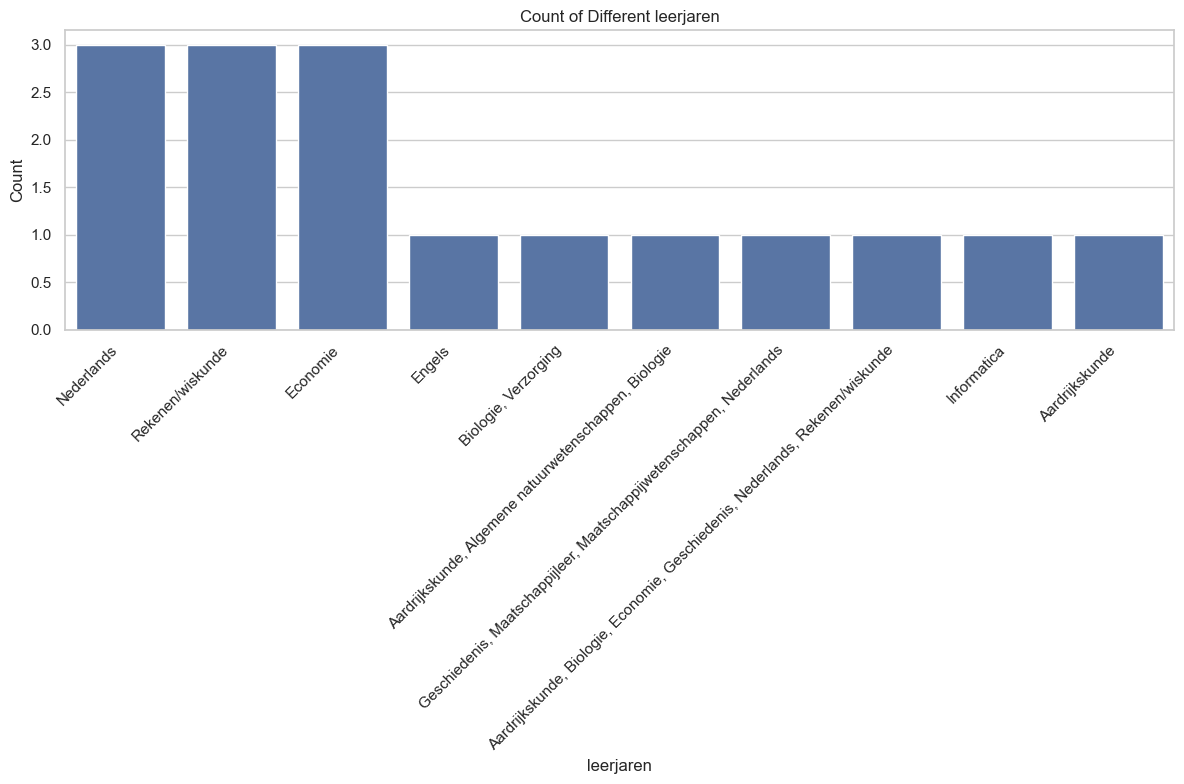

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.countplot(data=dataframe, x='vakken', order=dataframe['vakken'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.xlabel('leerjaren')
plt.ylabel('Count')
plt.title('Count of Different leerjaren')
plt.tight_layout()
plt.show()


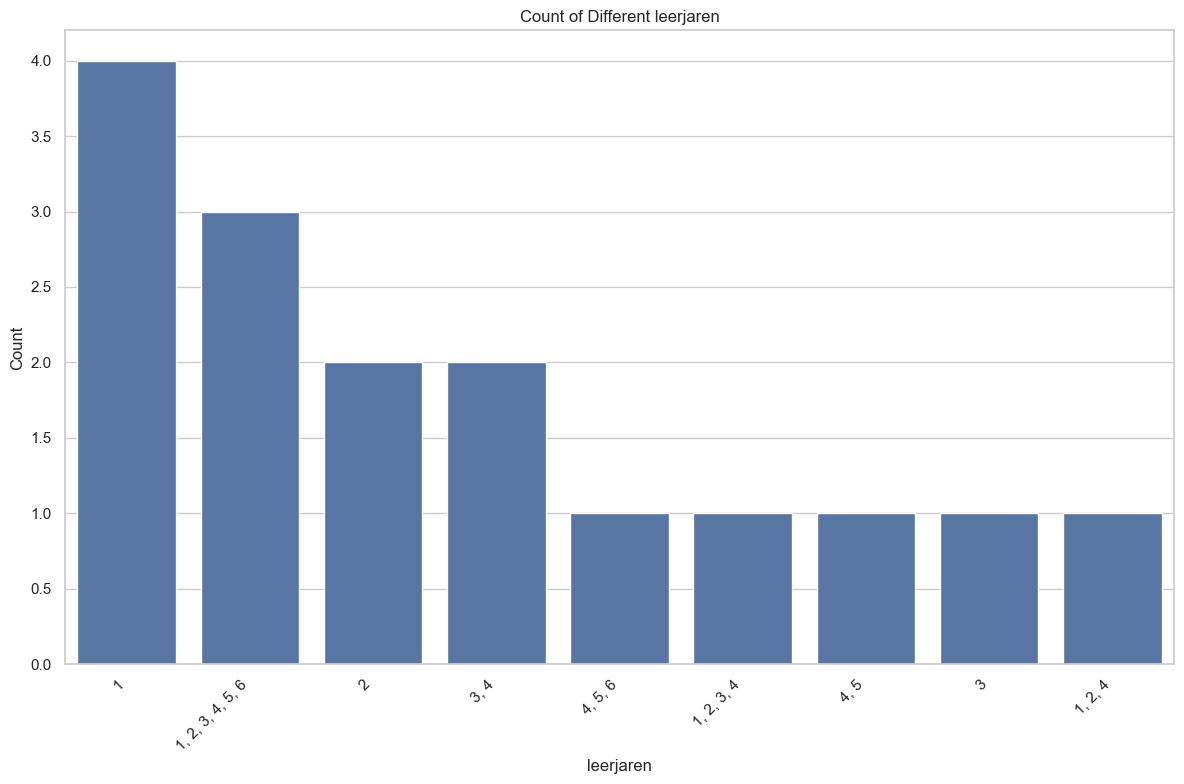

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.countplot(data=df, x='leerjaren', order=df['leerjaren'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.xlabel('leerjaren')
plt.ylabel('Count')
plt.title('Count of Different leerjaren')
plt.tight_layout()
plt.show()


We zien dat veel jeerlaren samen zijn (1,2)

In [16]:
# Assuming df is your DataFrame
vakken_list = dataframe['vakken'].unique()
print(vakken_list)


['Engels' 'Biologie, Verzorging' 'Nederlands' 'Rekenen/wiskunde'
 'Aardrijkskunde, Algemene natuurwetenschappen, Biologie'
 'Geschiedenis, Maatschappijleer, Maatschappijwetenschappen, Nederlands'
 'Aardrijkskunde, Biologie, Economie, Geschiedenis, Nederlands, Rekenen/wiskunde'
 'Economie' 'Informatica' 'Aardrijkskunde']


In [17]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import tensorflow as tf
import numpy as np

valid_subjects = [
    "Aardrijkskunde", "Algemene natuurwetenschappen", "Arabisch", 
    "Audiovisuele vormgeving", "Beeldende vormgeving", "Bewegen, sport en maatschappij", 
    "Biologie", "Chinees", "Culturele en kunstzinnige vorming", 
    "Dans", "Drama", "Duits", "Economie", "Engels", "Filosofie",
    "Frans", "Fries", "Geschiedenis", "Godsdienst", "Grieks", 
    "Handvaardigheid", "Informatica", "Italiaans", "Klassieke culturele vorming", 
    "Kunst algemeen", "Kunst en cultuur", "Latijn", "Levensbeschouwing", 
    "Lichamelijke opvoeding", "Literatuur", "Maatschappijleer", 
    "Maatschappijwetenschappen", "Management en organisatie", "Mens en maatschappij", 
    "Mens en natuur", "Muziek", "NaSk", "NaSk1", "NaSk2", 
    "Natuur, leven en technologie", "Natuur- en milieueducatie", "Natuurkunde", 
    "Nederlands", "Portugees", "Rekenen/wiskunde", 
    "Russisch", "Scheikunde", "Spaans", "Techniek", 
    "Tekenen", "Textiele vormgeving", "Turks", "Verzorging", 
    "Wiskunde A", "Wiskunde B", "Wiskunde C", "Wiskunde D"
]

def clean_vakken(vakken_list, valid_subjects):
    cleaned_vakken = []
    for vakken in vakken_list:
        subjects = [sub.strip() for sub in vakken.split(",")]
        found_subject = None
        for subject in subjects:
            if subject in valid_subjects:
                found_subject = subject
                break  # Take the first valid subject found
        if found_subject:
            cleaned_vakken.append(found_subject)
        else:
            cleaned_vakken.append(None)  # Mark as None to filter out later
    return cleaned_vakken

# Apply the cleaning function to the vakken column
dataframe['cleaned_vakken'] = clean_vakken(dataframe['vakken'].tolist(), valid_subjects)

# Filter out rows where the cleaned_vakken column is None
dataframe = dataframe.dropna(subset=['cleaned_vakken'])

 

In [18]:
dataframe

,text,vakken,leerjaren,niveaus,cleaned_vakken
12,English Tenses overview Met deze overzichten k...,Engels,"4, 5, 6","HAVO 4, HAVO 5, VWO 4, VWO 5, VWO 6",Engels
15,Introductie Deze les gaat over gezond en bewus...,"Biologie, Verzorging","1, 2, 3, 4","1, 2, 3, 4, HAVO 1, HAVO 2, HAVO 3, MBO, Nivea...",Biologie
28,0. Voor de docent 1. Zakelijke teksten 1.a. Ve...,Nederlands,1,"HAVO 1, VWO 1",Nederlands
33,0. Voor de docent 1. Zakelijke teksten Signaal...,Nederlands,2,"HAVO 2, VWO 2",Nederlands
34,Wiskunde A - Havo 4 en 5 Het complete examenpr...,Rekenen/wiskunde,"4, 5","HAVO 4, HAVO 5",Rekenen/wiskunde
38,Leerlijn Negatieve getallen Deze leerlijn best...,Rekenen/wiskunde,1,"HAVO 1, VWO 1",Rekenen/wiskunde
42,Bodem van Nederland arrangement gemaakt door H...,"Aardrijkskunde, Algemene natuurwetenschappen, ...","1, 2, 3, 4, 5, 6","2, 4, Beroepsonderwijs en Volwasseneneducatie,...",Aardrijkskunde
51,0. Voor de docent 1. Zakelijke teksten 1.06 De...,Nederlands,3,"HAVO 3, VWO 3",Nederlands
135,Algemene informatie Onderwerpen De collectie b...,Rekenen/wiskunde,1,"HAVO 1, VWO 1",Rekenen/wiskunde
207,Prinsjesdag,"Geschiedenis, Maatschappijleer, Maatschappijwe...","1, 2, 3, 4, 5, 6","1, 2, 3, 4, Beroepsonderwijs en Volwassenenedu...",Geschiedenis


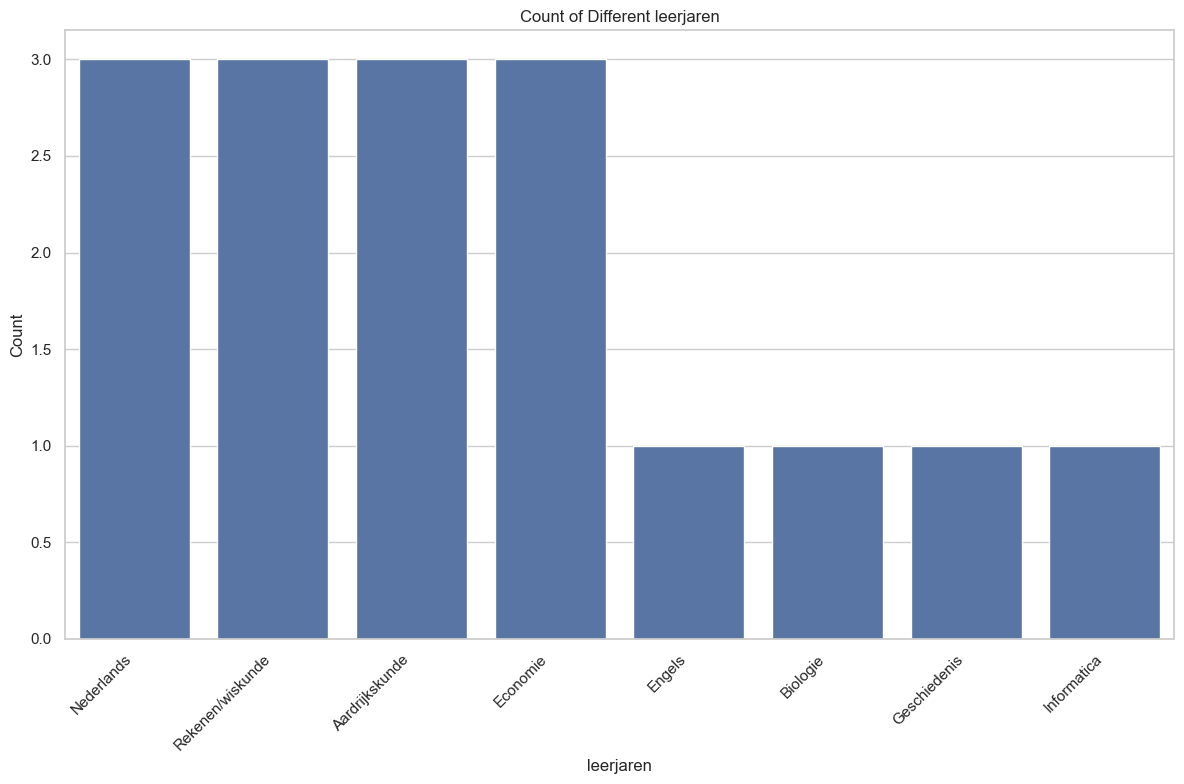

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style of the plot
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(12, 8))
sns.countplot(data=dataframe, x='cleaned_vakken', order=dataframe['cleaned_vakken'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.xlabel('leerjaren')
plt.ylabel('Count')
plt.title('Count of Different leerjaren')
plt.tight_layout()
plt.show()


In [20]:
dataframe['text']

12     English Tenses overview Met deze overzichten k...
15     Introductie Deze les gaat over gezond en bewus...
28     0. Voor de docent 1. Zakelijke teksten 1.a. Ve...
33     0. Voor de docent 1. Zakelijke teksten Signaal...
34     Wiskunde A - Havo 4 en 5 Het complete examenpr...
38     Leerlijn Negatieve getallen Deze leerlijn best...
42     Bodem van Nederland arrangement gemaakt door H...
51     0. Voor de docent 1. Zakelijke teksten 1.06 De...
135    Algemene informatie Onderwerpen De collectie b...
207                                          Prinsjesdag
215    . . Vanuit het project Innovatieplatform-VO va...
331                                                     
373    Inleiding Oriëntatie Je kunt prachtige games, ...
381    Start Waar gaat deze opdracht over? Deze opdra...
383    Wat is een CAO? Je gaat in deze opdracht een C...
391                                                     
Name: text, dtype: object

# Keywords van Vakken

Geen idee of we keywords nodig hebben (nog nooit mee gewerkt). ff opletten dat die niet hele tijd biologie voorspelt door die keywords

Aangezien onze traindata alleen vo-content is worden de voorspellingen ook gedaan op de vakken van vo-content. Onze data bevat ook andere vakken zoals dans, muziek, wiskunde A,B,C,D, spaans, tekenen, enzovoort. Deze komen allen uit de officiele vakken lijst, vakken.json.

Wij moeten dus bepalen of we deze keywords op basis doen van VO-content vakken of die van de officiele vakkenlijst. Accuracy gaat uiteraard omhoog wanneer we dit doen op de lijst van vo-content.

In [21]:
# Luca
biologie_keywords = ['omgeving', 'ordenen', 'blessures', 'organismen', 'geraamte', 'beenderen', 'lichaamshouding', 'zintuigen', 'zenuwstelsel', 'ogen', 'fotosynthese', 'voortplanting', 'zaad', 'eetgewoontes', 'voedingsstoffen', 'spijsvertering', 'ademhaling', 'seksualiteit', 'menstruatie', 'erfelijkheid', 'evolutie', 'celdeling', 'milieu', 'orgaan', 'zaadplanten', 'verbranding', 'voedselweb', 'overlevingsstrategieen', 'verteren', 'verkouden', 'ademhalingsstelsel', 'impulsen', 'zenuwstelsel', 'infectie', 'hartvaten', 'bloedvaten', 'hersenen', 'geraamte', 'beenverbindingen', 'spieren', 'menstruatiecyclus', 'geslachtsziekten', 'zwangerschap', 'voorbehoedsmiddelen', 'zwangerschap', 'skelet', 'ademhaling', 'natuur', 'hygiene', 'biologie', 'biotechnologie', 'levenskenmerken', 'ecosysteem', 'voedselweb', 'voedselketen', 'diergedrag', 'beenderen', 'bestuiving', 'spijsvertering', 'gebit', 'ademhaling', 'longziekten', 'kanker', 'afweersysteem', 'bloedtransfusies', 'broeikaseffect', 'afvalvertering', 'weefsel', 'dissimilatie', 'plantenweefsels', 'bloedsomloop', 'lymfe', 'nieren', 'skelet', 'schimmel', 'hormonen', 'infectie', 'bacterie', 'biotisch', 'erfelijk', 'mitose', 'meiose', 'monohybride', 'gedragsonderzoek', 'duurzaamheid', 'milieuvervuiling', 'bestuiving', 'diergedrag', 'ademhaling', 'bloed', 'erfelijkheid', 'broeikaseffect', 'schimmels', 'verloskundige', 'ziekenhuis', 'verpleegkundige', 'hormonen', 'anabolen', 'oogarts', 'neuroloog', 'revalidatiearts', 'eukaryoot', 'geneticus', 'hartklopping', 'osmoregulatie' ]
duits_keywords = [ 'deutsche', 'sprache', 'grammatik', 'konjugation', 'verben', 'nomen', 'adjektive', 'artikel', 'zeitformen', 'perfekt', 'imperfekt', 'präteritum', 'plusquamperfekt', 'kommaregeln', 'satzbau', 'wortschatz', 'redewendungen', 'aussprache', 'lesen', 'schreiben', 'sprechen', 'hören', 'komposition', 'aufsatz', 'textanalyse', 'lyrik', 'prosa', 'drama', 'literatur', 'schriftsteller', 'dichter', 'leseverstehen', 'hörverstehen', 'dialog', 'diskussion', 'referat', 'präsentation', 'diktat', 'wortbildung', 'synonyme', 'antonyme', 'falsche freunde', 'idiomatik', 'präpositionen', 'konjunktion', 'adverbien', 'pronomen', 'modalverben', 'imperativ', 'subjunktiv', 'indikativ', 'passiv', 'aktiv', 'rechtschreibung', 'schriftliche kommunikation', 'mündliche kommunikation', 'landeskunde', 'deutschland', 'österreich', 'schweiz', 'kultur', 'geschichte', 'gesellschaft', 'politik', 'wirtschaft', 'geografie', 'tourismus', 'bräuche', 'feste', 'traditionen', 'musik', 'kunst', 'film', 'theater', 'kulinarik', 'architektur', 'epochen', 'reformation', 'aufklärung', 'romantik', 'expressionismus', 'moderne', 'postmoderne', 'vergangenheit', 'gegenwart', 'zukunft', 'medien', 'zeitungen', 'zeitschriften', 'internet', 'soziale netzwerke', 'süddeutsche zeitung', 'frankfurter allgemeine', 'spiegel', 'focus', 'tagesschau', 'deutsche welle', 'bildbeschreibung', 'erörterung', 'interpretation', 'rezension', 'buchbesprechung', 'kollokation' ]
eco_keywords = ['economie', 'uitgaven', 'budget', 'inkomstenbronnen', 'inkomensverschillen', 'budget', 'productiefactoren', 'vraag en aanbod', 'bedrijfskosten', 'marketingmix', 'koopgedrag', 'lenen', 'hypotheek', 'onderhandelen', 'verzekering', 'onderneming', 'vennootschap', 'monopolie', 'economische groei', 'arbeidsmarkt', 'break-even', 'valuta', 'werkloosheid', 'inflatie', 'warenonderzoek', 'arbeidsovereenkomst', 'minimumloon', 'werknemer', 'werkgever', 'uitgaven', 'ontwikkelingslanden', 'productiefactoren', 'bedrijfskosten', 'koopgedrag', 'koopovereenkomst', 'werkgelegenheid', 'arbeidsmarkt', 'arbeidsverhoudingen', 'indexcijfers', 'minimumjeugdloon', 'kapitaal', 'betalingsbalans', 'crypto', 'hypotheekvormen', 'omzet', 'afzet', 'winst', 'reclame', 'reisverzekering', 'overschot', 'belasting', 'belastingsysteem', 'vergrijzing', 'aow', 'gevangenendilemma', 'collectieve sector', 'bruto binnenlands product', 'bruto buitenlands product', 'koopkracht', 'budgetlijn', 'marktvormen', 'surplus', 'beleggen', 'vermogensmarkt', 'conjunctuur']
mn_keywords = ['']

# Sami
eng_keywords = ['Engels', 'tekstanalyse', 'tekstbegrip', 'tekststructuur', 'literatuur', 'tekstsoorten', 'poëzie', 'proza', 'drama', 'literaire analyse', 'literaire termen', 'interpretatie', 'vertaling', 'vertaalvaardigheden', 'interpretatieve vaardigheden', 'citaat', 'context', 'plot', 'karakter', 'thema', 'stijl', 'setting', 'vertelperspectief', 'ironie', 'symboliek', 'figuurlijk taalgebruik', 'vergelijking', 'metafoor', 'personificatie', 'stijlfiguur', 'literair apparaat', 'literaire conventie', 'literaire stroming', 'literaire periode', 'klassiekers', 'romans', 'dichtbundels', 'toneelstukken', 'toneelteksten', 'vertalingen', 'letterkunde', 'Engelse literatuur', 'Amerikaanse literatuur', 'Britse literatuur', 'wereldliteratuur', 'literaire canon', 'literaire kritiek', 'literaire geschiedenis', 'literaire stijl', 'literaire analyse', 'schrijverschap', 'auteur', 'biografie', 'auteurschap', 'literaire context', 'historische context', 'culturele context', 'academisch Engels', 'formele Engelse taal', 'academische schrijfstijl', 'essay', 'academisch onderzoek', 'referenties', 'bibliografie', 'bronvermelding', 'citatie', 'peer review', 'literatuuronderzoek', 'bronnenonderzoek', 'bronnenanalyse', 'academisch Engels', 'discoursgemeenschap', 'academische conventies', 'academische terminologie', 'academische presentatie', 'argumentatie', 'discussie', 'debat', 'spreken in het openbaar', 'onderhandeling', 'diplomatie', 'retoriek', 'argumentatieve vaardigheden', 'overredingskracht', 'debatteren', 'onderzoeksrapport', 'presentatie', 'academische presentatie', 'spreekbeurt', 'publiek spreken', 'presentatietechnieken', 'publiek overtuigen', 'discussie leiden', 'tekstinterpretatie', 'culturele analyse', 'interculturele communicatie', 'taalverwerving', 'tweede taalverwerving', 'taalonderwijs', 'taalexamens', 'taalniveaus', 'Cambridge Engels', 'Engelse taalvaardigheid', 'Engelse taalvaardigheidstests']
geschiedenis_keywords = ['']
informatica_keywords = ['']
natuurkunde_keywords = ['']

# Jesse 180 cm
ned_keywords = ['grammatica', 'spelling', 'werkwoord', 'zelfstandig naamwoord', 'bijvoeglijk naamwoord', 'voorzetsel', 'bijwoord', 'zinsontleding', 'woordenschat', 'synoniem', 'antoniem', 'woordsoorten', 'zinsdelen', 'persoonlijk voornaamwoord', 'bezittelijk voornaamwoord', 'betrekkelijk voornaamwoord', 'literaire termen', 'poëzie', 'proza', 'drama', 'novelle', 'roman', 'kort verhaal', 'fabel', 'mythe', 'sprookje', 'epiek', 'lyriek', 'dramatiek', 'rijm', 'metrum', 'strofe', 'versregel', 'alliteratie', 'assonantie', 'metafoor', 'vergelijking', 'personificatie', 'hyperbool', 'understatement', 'ironie', 'sarcasme', 'stijlfiguren', 'beeldspraak', 'argumentatie', 'betogende tekst', 'beschouwende tekst', 'uiteenzettende tekst', 'inleiding', 'kern', 'slot', 'samenvatten', 'paraferen', 'tekststructuren', 'informatieve tekst', 'informatieve tekst', 'vertellende tekst', 'overtuigende tekst', 'activerende tekst', 'instruerende tekst', 'leesstrategieën', 'voorspellend lezen', 'globaal lezen', 'intensief lezen', 'kritisch lezen' ]
sk_keywords = ['atoom', 'molecuul', 'element', 'verbinding', 'chemische reactie', 'reactievergelijking',  'periodiek systeem', 'atoomnummer', 'massagetal', 'proton', 'neutron', 'elektron', 'valentie-elektron',  'ion', 'isotoop', 'kation', 'anion', 'molecuulformule', 'structuurformule', 'covalente binding',  'ionbinding', 'metaalbinding', 'polair', 'apolair', 'waterstofbrug', 'intermoleculaire krachten', 'stoichiometrie', 'mol', 'molaire massa', 'concentratie', 'oplossing', 'oplosmiddel', 'opgeloste stof', 'zure oplossing', 'basische oplossing', 'pH', 'neutralisatiereactie', 'titratie', 'indicator', 'zout', 'zoutoplossing', 'redoxreactie', 'oxidator', 'reductor', 'elektrolyse', 'elektrochemische cel', 'galvanische cel', 'halfreactie', 'oxidatie', 'reductie', 'activeringsenergie', 'katalysator', 'reactiesnelheid', 'evenwichtsreactie', 'chemisch evenwicht', 'Le Chatelier', 'druk', 'temperatuur', 'concentratieverandering', 'gaswetten', 'ideale gaswet', 'Boyle', 'Charles', 'Gay-Lussac', 'Avogadro', 'gassen', 'vloeistoffen', 'vaste stoffen', 'faseovergang', 'sublimatie', 'condenseren', 'verdampen', 'smelten', 'stollen', 'mengsel', 'zuivere stof', 'destillatie', 'filtratie', 'chromatografie', 'extractie', 'adsorptie', 'destillaat', 'residu', 'precipitatie', 'neerslagreactie', 'scheidingsmethode', 'carbonchemie', 'koolstofverbinding', 'alkaan', 'alkeen', 'alkyn', 'aromaat', 'alkohol', 'ether', 'aldehyde', 'keton', 'carboxylzuur', 'ester', 'amine', 'amide', 'polymeer', 'monomeer', 'kunststof', 'biochemie', 'enzym', 'eiwit', 'vet', 'koolhydraat', 'nucleotide', 'DNA', 'RNA', 'biomolecuul', 'metabolisme', 'cellulose', 'stijfsel', 'glucose', 'fructose', 'sacharose', 'lactose', 'chemische industrie', 'milieukunde', 'duurzaamheid', 'green chemistry', 'hernieuwbare energie', 'fossiele brandstoffen']
wisk_keywords =['getal', 'optellen', 'aftrekken', 'vermenigvuldigen', 'delen', 'breuk', 'decimaal', 'procent', 'ratio', 'verhouding', 'machtsverheffen', 'worteltrekken', 'volgorde van bewerkingen', 'bewijs', 'axioma', 'stelling', 'meetkunde', 'punt', 'lijn', 'vlak', 'hoek', 'driehoek', 'vierhoek', 'cirkel', 'ellips', 'parallel', 'loodrecht', 'evenwijdig', 'congruent', 'gelijkvormig', 'symmetrie', 'translatie', 'rotatie', 'spiegeling', 'reflexie', 'coördinaten', 'assenstelsel', 'grafiek', 'functie', 'vergelijking', 'ongelijkheid', 'parabool', 'hyperbool', 'exponentiële functie', 'logaritmische functie', 'sinusfunctie', 'cosinusfunctie', 'tangensfunctie', 'differentiaalrekening', 'afgeleide', 'limiet', 'continuïteit', 'integraalrekening', 'bepaalde integraal', 'onbepaalde integraal', 'sommatie', 'reeks', 'limiet van een rij', 'meetkundige reeks', 'convergentie', 'divergentie', 'differentiaalvergelijking', 'lineaire algebra', 'matrix', 'vector', 'eigenwaarde', 'eigenvector', 'lineaire vergelijking', 'determinant', 'vectorruimte', 'scalair product', 'vectorproduct', 'lineaire transformatie', 'stelsel van lineaire vergelijkingen', 'gauss-eliminatie', 'kronecker-delta', 'combinatoriek', 'permutatie', 'combinatie', 'kansrekening', 'kans', 'waarschijnlijkheid', 'kansverdeling', 'normale verdeling', 'binomiale verdeling', 'hypergeometrische verdeling', 'poissonverdeling', 'kansfunctie', 'statistiek', 'steekproef', 'gemiddelde', 'mediaan', 'modus', 'variantie', 'standaarddeviatie', 'correlatie', 'regressie', 't-toets', 'chi-kwadraat toets', 'ANOVA', 'betrouwbaarheidsinterval', 'hypothesetoetsing', 'significantieniveau', 'afwijzingsgebied', 'p-waarde', 'beslissingsregel', 'afgeleide', 'primitieve functie', 'hoofdrekenen', 'algebra', 'meetkunde', 'trigonometrie', 'analytische meetkunde', 'goniometrie', 'exponentiële functies', 'logaritmische functies', 'afgeleiden', 'integralen', 'limieten', 'reeksen', 'vectorrekening', 'complex getal', 'differentiaalvergelijkingen', 'lineaire algebra', 'kansrekening', 'statistiek', 'bewijstechnieken', 'meetkundige figuren', 'analytische meetkunde', 'coördinatengeometrie']
ak_keywords = ['aarde', 'geografie', 'landschap', 'platentektoniek', 'aardbeving', 'vulkaan', 'erosie', 'klimaat', 'weer', 'atmosfeer', 'neerslag', 'temperatuur', 'luchtdruk', 'wind', 'luchtvochtigheid', 'klimaatclassificatie', 'natuurlijke hulpbronnen', 'mineralen', 'grondstoffen', 'water', 'energiebronnen', 'fossiele brandstoffen', 'duurzame energie', 'landbouw', 'veeteelt', 'gewassen', 'irrigatie', 'landbouwmethoden', 'intensieve landbouw', 'extensieve landbouw', 'verstedelijking', 'stedelijke planning', 'megastad', 'stadsplanning', 'infrastructuur', 'stedelijke ontwikkeling', 'stedelijke vernieuwing', 'demografie', 'bevolking', 'bevolkingsgroei', 'bevolkingsdichtheid', 'migratie', 'immigratie', 'emigratie', 'vergrijzing']
#engels en nederlands

### Hier is de valid_subjects lijst zoals die is ingevuld in vakken.json

In [22]:
valid_subjects = [
    "Aardrijkskunde", "Algemene natuurwetenschappen", "Arabisch", 
    "Audiovisuele vormgeving", "Beeldende vormgeving", "Bewegen, sport en maatschappij", 
    "Biologie", "Chinees", "Culturele en kunstzinnige vorming", 
    "Dans", "Drama", "Duits", "Economie", "Engels", "Filosofie",
    "Frans", "Fries", "Geschiedenis", "Godsdienst", "Grieks", 
    "Handvaardigheid", "Informatica", "Italiaans", "Klassieke culturele vorming", 
    "Kunst algemeen", "Kunst en cultuur", "Latijn", "Levensbeschouwing", 
    "Lichamelijke opvoeding", "Literatuur", "Maatschappijleer", 
    "Maatschappijwetenschappen", "Management en organisatie", "Mens en maatschappij", 
    "Mens en natuur", "Muziek", "NaSk", "NaSk1", "NaSk2", 
    "Natuur, leven en technologie", "Natuur- en milieueducatie", "Natuurkunde", 
    "Nederlands", "Portugees", "Rekenen/wiskunde", 
    "Russisch", "Scheikunde", "Spaans", "Techniek", 
    "Tekenen", "Textiele vormgeving", "Turks", "Verzorging", 
    "Wiskunde A", "Wiskunde B", "Wiskunde C", "Wiskunde D"
]

# Modeling

Accuracy komt al op 0.5 zonder enige preprocessing, run onderstaande cel maar niet.

In [23]:

# Apply the cleaning function to the vakken column
dataframe['cleaned_vakken'] = clean_vakken(dataframe['vakken'].tolist(), valid_subjects)

# Filter out rows where the cleaned_vakken column is None
dataframe = dataframe.dropna(subset=['cleaned_vakken'])

# Verify the length of the cleaned DataFrame
assert len(dataframe['cleaned_vakken']) == len(dataframe), "Mismatch in lengths after cleaning vakken"

# Preprocessing texts
texts = dataframe['text'].tolist()

# Tokenizing and padding sequences
tokenizer = Tokenizer(num_words=10000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
padded_sequences = pad_sequences(sequences, padding='post', maxlen=300)

# Encode the 'cleaned_vakken' column to categorical labels using LabelEncoder
le_vakken = LabelEncoder()
valid_vakken_subset = dataframe['cleaned_vakken']
le_vakken.fit(valid_subjects)

vakken_encoded = le_vakken.transform(valid_vakken_subset)

# Splitting the dataset
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, vakken_encoded, test_size=0.2, random_state=42)

# Building the LSTM model
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=10000, output_dim=128, input_length=300),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=False)),  # Final LSTM layer without return_sequences
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(valid_subjects), activation='softmax')  # Softmax activation for multi-class classification
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Adding early stopping to prevent overfitting
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Training the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])

# Evaluating the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy*100:.2f}%")

# To predict
predictions = model.predict(X_test)
predicted_labels = np.argmax(predictions, axis=1)

# Convert numerical predictions back to label names
predicted_vakken = le_vakken.inverse_transform(predicted_labels)

# Checking a few predictions
for i in range(10):
    print(f"True: {le_vakken.inverse_transform([y_test[i]])[0]}, Pred: {le_vakken.inverse_transform([predicted_labels[i]])[0]}")

ValueError: Unrecognized keyword arguments passed to Embedding: {'input_length': 300}

## nieuw

We hebben handmatig een lijst met keywords gemaakt voor ieder vak, maar om dit te controleren/verbeteren proberen we ook met behulp van mutual information keywords te vinden.

In [25]:
import pandas as pd
import string
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_classif
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [52]:
nltk.download('stopwords')

# standaard text preprocessing
stop_words = set(stopwords.words('dutch'))
stemmer = SnowballStemmer('dutch')

# interpunctie en stopwoorden weghalen ook stam van ieder woord pakken
def preprocess_text(text):
    if isinstance(text, str):
        text = text.lower()
        text = text.translate(str.maketrans('', '', string.punctuation))
        tokens = text.split()
        tokens = [stemmer.stem(word) for word in tokens if word not in stop_words]
        return ' '.join(tokens)
    else:
        return ''

#uitvoeren
dataframe['processed_text'] = dataframe['text'].apply(preprocess_text)



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\jesse\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [54]:
#hier gaat iets fout


# vectorizeren en waarderen van de woorden
vectorizer = TfidfVectorizer(max_features=1000)
X = vectorizer.fit_transform(dataframe['processed_text']).toarray()

# Print matrix
print(X)

# Print feature namen
print(vectorizer.get_feature_names_out())

['10' '100' '106' '11' '11000' '12' '125' '150' '16' '1700' '1a' '1b'
 '200' '2009' '2011' '2012' '2015' '207' '208' '210' '2100' '211' '212'
 '213' '214' '217' '300' '35' '36' '3b' '400' '400700' '402' '403' '404'
 '405' '406' '4a' '4b' '50' '503' '550900' '5a' '5b' '5c' '61' '611' '612'
 '613' '614' '62' '63' '64' '66' '68' '6a' '6b' '6c' '75' '76' '77' '78'
 '79' '7breuk' '9getallenlijn' 'a4tjes' 'aagst' 'aanbevol' 'aangegev'
 'aanhoud' 'aanmeldingsformulier' 'aanpak' 'aanpakwerkdocument' 'aantal'
 'aantreff' 'aanvrag' 'aanzicht' 'aard' 'aardappel' 'aardkorst' 'aardkund'
 'aardlag' 'accijnz' 'achter' 'achtergrond' 'achtergrondartikel' 'actief'
 'activiteit' 'advies' 'adviseert' 'af' 'afgebrok' 'afgelop' 'afgezet'
 'afhank' 'afkort' 'afl' 'aflever' 'aflez' 'aflop' 'afneemt' 'afsluit'
 'afstand' 'aftrek' 'akkerbouw' 'albert' 'alcohol' 'algemen' 'all'
 'allemal' 'allen' 'allerlei' 'ander' 'antwoord' 'aow' 'aowleeftijd'
 'arrangement' 'artikel' 'auteursrecht' 'balansdag' 'basis'
 'basis

In [55]:
from sklearn.preprocessing import LabelEncoder

# numeriek maken
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(dataframe['cleaned_vakken'])
y

array([3, 1, 6, 6, 7, 7, 0, 6, 7, 4, 0, 2, 5, 2, 2, 0])

In [56]:
from sklearn.feature_selection import mutual_info_classif
import numpy as np
#mi scores
mi_scores = mutual_info_classif(X, y, discrete_features=True)

feature_names = vectorizer.get_feature_names_out()

mi_df = pd.DataFrame({'feature': feature_names, 'mi_score': mi_scores})
mi_df = mi_df.sort_values(by='mi_score', ascending=False)

print(mi_df.head(20))
# geen vak gerelateerde woorden

C:\Users\jesse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\jesse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\jesse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for 

       feature  mi_score
308    gebruik  1.201542
878    volgend  1.091967
782     uitleg  1.008137
357       goed  1.008137
537        mak  0.972621
832  verschill  0.972621
245     docent  0.918046
925       welk  0.888790
302         ga  0.888790
982       zien  0.888790
482       kijk  0.888790
309   gebruikt  0.885343
498        kun  0.885343
732      tekst  0.798700
499       kunt  0.798700
991       zoek  0.798700
896       vrag  0.798700
770       twee  0.798700
318    gemaakt  0.789562
250       drie  0.789562


C:\Users\jesse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\jesse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for target
  warnings.warn(msg, UserWarning)
C:\Users\jesse\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\cluster\_supervised.py:66: UserWarning: Clustering metrics expects discrete values but received continuous values for label, and multiclass values for 

## Mutual Information vs Correlation vs Handmatig

woorden zullen niet altijd bij een vak blijven, sommige woorden komen overal voor en hebben weinig correlatie, sommige een beetje een sommige veel, zo zal het woord botten het vaakst voorkomen bij Biologie, maar ook wel eens bij geschiedenis en nooit bij economie. er zijn 3 methodes die ons handig lijken.

MI

Correlation

Handmatig